# Multi-Label Classification : Age, Sex and Race

Pour accéder aux données, il suffit de décompresser le fichier "UTKFace.tar.gz". Il doit être dans le même dossier que notre fichier python. Lien de la page où récupérer "Aligned and Cropped Faces": https://susanqq.github.io/UTKFace/. Un dossier "UTKFace" comprenant l'ensemble des images est alors créé.


In [1]:
import tarfile
tf = tarfile.open("UTKFace.tar.gz", mode="r")
tf.extractall(members=None)

Les packages suivants sont nécessaires à l'exécution du code.

In [49]:
from PIL import Image
import numpy as np
import shutil
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets
import torch
import time
%matplotlib inline
import pandas as pd
import random
import torch.nn.functional as F
from IPython.display import Image as Img

Pour accéder aux images, on se place dans le dossier "UTKFace".

os.getcwd()

In [3]:
os.chdir('UTKFace')

Les fonctions suivantes permettent d'extraire les différents labels issues du titre de chaque image. Wordtest est ici le titre sous forme de string.

In [4]:
def extract_label_str(wordtest,rate):
    suffix=".jpg.chip.jpg"
    wordtest=wordtest[:-len(suffix)]
    lstr=wordtest.split("_")
    age=lstr[0]
    sex="male"
    if lstr[1]==str(1):
        sex="female"
    nb=lstr[2]
    race='white'
    if (nb==str(1)):
        race='black'
    if (nb==str(2)):
        race='asian'
    if (nb==str(3)):
        race='indian'
    if (nb==str(4)):
        race='others'        
    val="train"
    x=random.uniform(0, 1)
    if x<rate:
        val="valid"
    return(age,sex,race,val)

In [5]:
def extract_labels_int(wordtest) :
    suffix=".jpg.chip.jpg"
    wordtest=wordtest[:-len(suffix)]
    lstr=wordtest.split("_")
    age=int(lstr[0])
    sex=int(lstr[1])
    race=int(lstr[2])   
    return(age,sex,race)

On séléctionne les titres de l'ensemble des images présente dans le dossier UTKFace. On obtient une liste de titre que l'on transforme en labels.

In [6]:
l=os.listdir()

l.sort()
l=l[:-4]
lAge=[]
lSex=[]
lRace=[]
lll=[]
for i in range(len(l)):
    age,sex,race=extract_labels_int(l[i])
    lAge=lAge+[age]
    lSex=lSex+[sex]
    lRace=lRace+[race]
    lll=lll+[(age,sex,race)]


La fonction transformerlimage permet d'ouvrir une image de la transformer en tenseur puis de la normaliser avant l'injection dans le réseau. TransforBatch permet d'appliquer la fonction présente sur un batch. Ainsi, pour des soucis de mémoires, le préprocessing est réalisé au fure et à mesure de chaque batch.

In [7]:
def transformer1image(word):
    im = Image.open(word)
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    im_format = transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor(), normalize])
    
    q=im_format(im)
    return(q)

def transforBatch(name_list):
    lp=[]
    for i in range(len(name_list)):
        tens=transformer1image(name_list[i])
        lp=lp+[tens]
        llp=torch.stack(lp)
    return(llp)

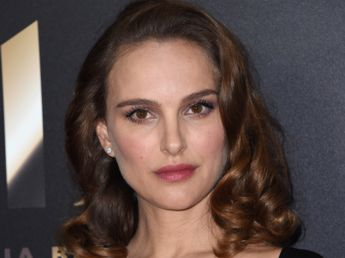

In [244]:
image_name = "photo_nat.jpeg"
image = Variable(transforBatch([image_name]))
Img(filename=image_name)

In [245]:
sexpred,agepred,racepred=cnn(image)
print(torch.argmax(sexpred),torch.argmax(agepred),torch.argmax(racepred))

tensor(1) tensor(26) tensor(0)


In [8]:
lImage=l

lImage=np.asarray(lImage)
lAge=np.asarray(lAge)
lSex=np.asarray(lSex)
lRace=np.asarray(lRace)


On crée maintenant les training et test sets en mélangeant simultanément les données. Le découpage entre le training et test set est de 75%.

In [9]:
from sklearn.utils import shuffle

lImage, lAge,lSex,lRace = shuffle(lImage,lAge,lSex,lRace)
batch_size=64
rate=0.75
n=len(lImage)
q=int(rate*n)

lImageTrain=lImage[:q]
lSexTrain=lSex[:q]
lRaceTrain=lRace[:q]
lAgeTrain=lAge[:q]

lImageTest=lImage[q:]
lSexTest=lSex[q:]
lRaceTest=lRace[q:]
lAgeTest=lAge[q:]

n=len(lAgeTrain)
nindice=n//batch_size

Nous créons maintenant notre réseau adapté à la classification. Jusqu'à self.fc2, les couches sont spécifiques à chaque label. Ensuite, pour chaque output, nous appliquons une couche dépendant du nombre de classes à utiliser.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,96,kernel_size=7,stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96,256,kernel_size=5,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256,384,kernel_size=3,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.fc1 = nn.Linear(384*6*6,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,2)
        self.fc4 = nn.Linear(512,106)
        self.fc5 = nn.Linear(512,5)
        
        

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        #print out.size()
        out = F.dropout(F.relu(self.fc1(out)))
        out = F.dropout(F.relu(self.fc2(out)))
        sex = self.fc3(out)
        age = self.fc4(out)
        race = self.fc5(out)

        return (sex,age,race)

In [11]:
use_gpu = torch.cuda.is_available()

Pour la suite, il est possible d'utiliser le précédent model ou un model que nous avons préalablement entrainé (partie en italique). Pour l'optimisation de la loss par gradient boosting, l'utilisateur est libre de modifier le pas de temps et l'inertie.

In [116]:
cnn = CNN()
cnn.load_state_dict(torch.load('/home/mathieu/Documents/Projet_final_deep/model'))
cnn.eval()
#print(cnn.state_dict())
if use_gpu:
    cnn.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.001,momentum=0.9)

loss_history = []
num_epochs = 10
train_acc_history = []
val_acc_history = []
epoch_history = []
learning_rate = 0.001
best_val_acc = 0.0

Cette fonction permet de tester le modèle sur un jeu de donnée passée en argument. On renvoie l'accuracy pour le sexe et l'ethnie. Pour l'age, il s'agit de la moyenne de la valeur absolue des erreurs.

In [13]:
def testA(cnn,imageTest,sexTest,ageTest,raceTest):
    batch_size = 40
    totalSize = len(imageTest)
    iterations = totalSize//40
    tombeJuste = (totalSize%40 != 0)
    sexCount = 0
    accAge = 0
    raceCount = 0
    
    for i in range(iterations+tombeJuste):
        batchImage, batchSex, batchAge, batchRace = imageTest[40*i:40*(i+1)],sexTest[40*i:40*(i+1)],ageTest[40*i:40*(i+1)],raceTest[40*i:40*(i+1)]
        currentBatchSize = len(batchImage)
        lInput = Variable(transforBatch(batchImage))
        sexOutput,ageOutput,raceOutput = cnn(lInput)
        sexpred = torch.argmax(sexOutput, dim=1)
        agepred = torch.argmax(ageOutput, dim=1)
        racepred = torch.argmax(raceOutput, dim=1)
        
        sexArray = np.array([sexpred[i] == batchSex[i] for i in range(currentBatchSize)])
        sexCount += np.sum(sexArray)
    
        ageArray = np.array([abs(agepred[i]-batchAge[i]) for i in range(currentBatchSize)])
        accAge += np.sum(ageArray)
    
        raceArray = np.array([racepred[i] == batchRace[i] for i in range(currentBatchSize)])
        raceCount += np.sum(raceArray)

    return(sexCount/totalSize, accAge/totalSize, raceCount/totalSize)

L'indice définit le nombre de points dans le training set que l'on souhaite utiliser.

In [16]:
N = 2000
testA(cnn,lImageTest[:N],lSexTest[:N],lAgeTest[:N],lRaceTest[:N])

(0.725, 14.879, 0.458)

On entraine maintenant le  modèle sur le training set. Pour privilégier un label en particulier, l'utilisateur peut modifier les poids a, b et c des loss. On calcule également la loss et les différentes métrics sur chaque label pour le testing set.

In [14]:
epochs=2
N = 1000
a=6
b=1
c=2

tabepochs=[0]
sex,age,race=testA(cnn,lImageTest[:N],lSexTest[:N],lAgeTest[:N],lRaceTest[:N])                
accuracysex=[sex]
errorage=[age]
accuracyrace=[race]
tabloss=[14.99]
tenstabloss=[]

for epoch in range(epochs):
        permutation=np.arange(nindice)
        permutation=shuffle(permutation)
        tabepochs=tabepochs+[epoch+1]
        for i in range(len(permutation)):
            try:
                indice=permutation[i]*batch_size                        
                lSexBatch=torch.from_numpy(lSexTrain[indice:indice+batch_size])
                lRaceBatch=torch.from_numpy(lRaceTrain[indice:indice+batch_size])
                lAgeBatch=torch.from_numpy(lAgeTrain[indice:indice+batch_size])
            
                lSexBatch=Variable(lSexBatch)
                lRaceBatch=Variable(lRaceBatch)
                lAgeBatch=Variable(lAgeBatch)
            
                lImageBatch=lImageTrain[indice:indice+batch_size]
            
                lInput=transforBatch(lImageBatch)
                lInput=Variable(lInput)
            
                if use_gpu:
                    lInput,lSexBatch,lRaceBatch,lAgeBatch = lInput.cuda(),lSexBatch.cuda(),lRaceBatch.cuda(),lAgeBatch.cuda()
            
                sexpred,agepred,racepred=cnn(lInput)
                loss1=criterion(sexpred,lSexBatch)
                loss2=criterion(racepred,lRaceBatch)
                loss3=criterion(agepred,lAgeBatch)
            
                loss=a*loss1+b*loss2+c*loss3
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if (i+1) % 5 == 0:
                    print ('Epoch[%d/%d], Iter [%d/%d] Loss: %.4f' 
                        %(epoch+1, num_epochs, i+1, len(lSexTrain)//50, loss))
                    print('Accuracy: ', testA(cnn,lImageBatch,lSexBatch,lAgeBatch,lRaceBatch))
                    #torch.save(cnn.state_dict(), '/home/mathieu/Documents/Projet_final_deep/model')
            except:
                print('runtime error')
        sex,age,race=testA(cnn,lImageTest[:N],lSexTest[:N],lAgeTest[:N],lRaceTest[:N])                
        accuracysex=accuracysex+[sex]
        errorage=errorage+[age]
        accuracyrace=accuracyrace+[race]
        tenstabloss=tenstabloss+[loss]
            


Epoch[1/10], Iter [5/355] Loss: 15.0210
Accuracy:  (0.609375, 31.8125, 0.265625)
Epoch[1/10], Iter [10/355] Loss: 14.6249
Accuracy:  (0.671875, 27.46875, 0.34375)
Epoch[1/10], Iter [15/355] Loss: 14.6935
Accuracy:  (0.578125, 22.171875, 0.375)
runtime error
Epoch[1/10], Iter [20/355] Loss: 14.1898
Accuracy:  (0.609375, 16.203125, 0.53125)
Epoch[1/10], Iter [25/355] Loss: 14.6660
Accuracy:  (0.59375, 16.25, 0.515625)
Epoch[1/10], Iter [30/355] Loss: 13.7444
Accuracy:  (0.6875, 16.6875, 0.4375)
Epoch[1/10], Iter [35/355] Loss: 14.1166
Accuracy:  (0.5, 17.640625, 0.40625)
Epoch[1/10], Iter [40/355] Loss: 14.2218
Accuracy:  (0.640625, 15.890625, 0.375)
Epoch[1/10], Iter [45/355] Loss: 14.5103
Accuracy:  (0.65625, 18.8125, 0.5625)
Epoch[1/10], Iter [50/355] Loss: 12.7665
Accuracy:  (0.671875, 14.890625, 0.375)
runtime error
Epoch[1/10], Iter [60/355] Loss: 13.5197
Accuracy:  (0.625, 17.21875, 0.484375)
Epoch[1/10], Iter [65/355] Loss: 13.2336
Accuracy:  (0.671875, 17.625, 0.5)
Epoch[1/10], 

Epoch[2/10], Iter [235/355] Loss: 10.9090
Accuracy:  (0.875, 13.828125, 0.53125)
Epoch[2/10], Iter [240/355] Loss: 10.7280
Accuracy:  (0.71875, 15.625, 0.515625)
Epoch[2/10], Iter [245/355] Loss: 11.1687
Accuracy:  (0.875, 16.78125, 0.5)
Epoch[2/10], Iter [250/355] Loss: 11.5241
Accuracy:  (0.84375, 13.140625, 0.359375)
Epoch[2/10], Iter [255/355] Loss: 10.7182
Accuracy:  (0.890625, 12.953125, 0.421875)
Epoch[2/10], Iter [260/355] Loss: 9.6568
Accuracy:  (0.921875, 10.046875, 0.484375)
Epoch[2/10], Iter [265/355] Loss: 10.0554
Accuracy:  (0.84375, 11.359375, 0.515625)
Epoch[2/10], Iter [270/355] Loss: 11.4439
Accuracy:  (0.78125, 13.4375, 0.453125)
runtime error
Epoch[2/10], Iter [275/355] Loss: 9.9838
Accuracy:  (0.890625, 14.484375, 0.609375)
runtime error


KeyboardInterrupt: 

In [58]:
for i in range(epochs):
    tabloss.append(tenstabloss[i].item())


[14.99, 11.814105033874512, 10.217668533325195, 10.089146614074707, 9.765390396118164, 10.068646430969238, 8.955753326416016, 8.825361251831055, 8.857754707336426, 10.029623031616211, 8.703582763671875]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.53125, 0.849, 0.874, 0.875, 0.886, 0.88, 0.879, 0.902, 0.888, 0.886, 0.898]
[29.65625, 14.713, 13.955, 12.888, 12.197, 11.017, 11.512, 11.331, 11.326, 11.041, 9.645]
[0.328125, 0.445, 0.486, 0.523, 0.546, 0.575, 0.567, 0.595, 0.6, 0.613, 0.604]


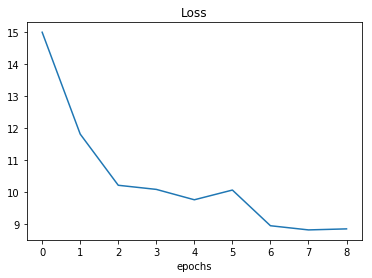

In [44]:
import matplotlib.pyplot as plt
plt.plot(epochs,tabloss)
plt.title("Loss")
plt.xlabel('epochs')
plt.show()

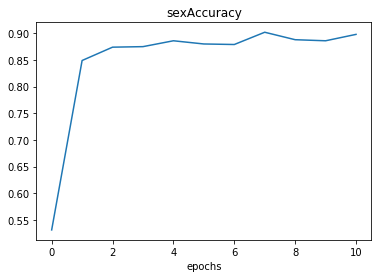

In [59]:
plt.plot(epochs,accuracysex)
plt.title("sexAccuracy")
plt.xlabel('epochs')
plt.show()

In [62]:
torch.save(cnn.state_dict(), '/home/mathieu/Documents/Projet_final_deep/model')

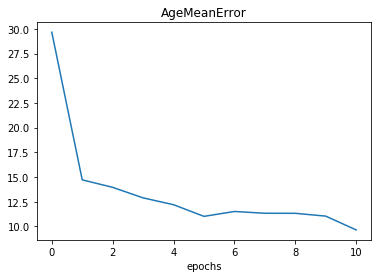

In [60]:
plt.plot(epochs,errorage)
plt.title("AgeMeanError")
plt.xlabel('epochs')
plt.show()

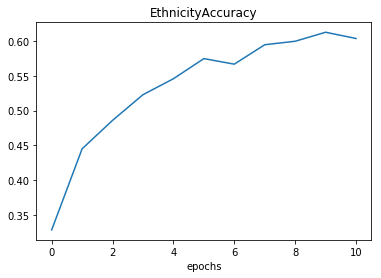

In [61]:
plt.plot(epochs,accuracyrace)
plt.title("EthnicityAccuracy")
plt.xlabel('epochs')
plt.show()